<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task2_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

from torch.profiler import profile, ProfilerActivity, record_function
import torch.cuda.profiler as profiler

## 1. Define your first network

In [2]:
# ResNet Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.silu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## 2. Implement training loop and test function

In [3]:
# I put in quite a bit of extra stuff to profile/optimizing training
# since I have an interview coming where I need to do that

def train(model, device, train_loader, optimizer, epoch):
    model.to(device)
    model.train()
    model.compile()

    running_loss = 0.0
    correct = 0
    total = 0
    loss_curve = []

    scaler = torch.amp.GradScaler("cuda")

    for epoch in tqdm.tqdm(range(epoch)):
      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()

          with torch.autocast(device_type="cuda", dtype=torch.float16):
              output = model(data)
              loss = F.cross_entropy(output, target)

          scaler.scale(loss).backward()

          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()
          _, predicted = output.max(1)
          total += target.size(0)
          correct += predicted.eq(target).sum().item()

          if batch_idx % 100 == 0:
              print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
              loss_curve.append(loss.item())

    return running_loss / len(train_loader), loss_curve

def test(model, device, test_loader):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    model.eval()

    total_loss = 0.0
    num_batches = 0

    num_correct = 0
    num_total = 0

    for input, labels in test_loader:
        input = input.to(device)
        labels = labels.to(device)

        logits = model(input)

        loss = F.nll_loss(logits, labels)

        top1 = torch.argmax(logits, dim=1)

        num_correct += (top1 == labels).sum().item()
        num_total += top1.shape[0]

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Total test loss was {avg_loss}")

    print(f"Accuracy was {100 * num_correct / num_total}")


## 3. Dataset loading


In [4]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

load_mnist = False

if load_mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
    # Data transforms
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # Dataset and DataLoader
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=384, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=8, pin_memory=True)




100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


## 4. Put Everything Together

  0%|          | 0/16 [00:00<?, ?it/s]

Batch 0, Loss: 2.3168, Acc: 11.46%
Batch 100, Loss: 1.2328, Acc: 43.37%


  6%|▋         | 1/16 [00:57<14:16, 57.07s/it]

Batch 0, Loss: 1.1813, Acc: 46.12%
Batch 100, Loss: 0.9917, Acc: 52.74%


 12%|█▎        | 2/16 [01:01<06:01, 25.82s/it]

Batch 0, Loss: 0.8887, Acc: 54.20%
Batch 100, Loss: 0.9142, Acc: 58.33%


 19%|█▉        | 3/16 [01:04<03:25, 15.81s/it]

Batch 0, Loss: 0.7110, Acc: 59.40%
Batch 100, Loss: 0.6970, Acc: 62.49%


 25%|██▌       | 4/16 [01:08<02:13, 11.12s/it]

Batch 0, Loss: 0.6822, Acc: 63.25%
Batch 100, Loss: 0.5737, Acc: 65.53%


 31%|███▏      | 5/16 [01:12<01:33,  8.54s/it]

Batch 0, Loss: 0.5071, Acc: 66.14%
Batch 100, Loss: 0.5160, Acc: 68.00%


 38%|███▊      | 6/16 [01:16<01:09,  6.99s/it]

Batch 0, Loss: 0.4209, Acc: 68.49%
Batch 100, Loss: 0.5732, Acc: 70.01%


 44%|████▍     | 7/16 [01:20<00:54,  6.03s/it]

Batch 0, Loss: 0.4374, Acc: 70.40%
Batch 100, Loss: 0.4770, Acc: 71.67%


 50%|█████     | 8/16 [01:24<00:42,  5.36s/it]

Batch 0, Loss: 0.3868, Acc: 72.02%
Batch 100, Loss: 0.4687, Acc: 73.10%


 56%|█████▋    | 9/16 [01:28<00:34,  4.96s/it]

Batch 0, Loss: 0.4166, Acc: 73.41%
Batch 100, Loss: 0.4366, Acc: 74.40%


 62%|██████▎   | 10/16 [01:32<00:27,  4.64s/it]

Batch 0, Loss: 0.4408, Acc: 74.66%
Batch 100, Loss: 0.4479, Acc: 75.54%


 69%|██████▉   | 11/16 [01:36<00:22,  4.43s/it]

Batch 0, Loss: 0.4064, Acc: 75.77%
Batch 100, Loss: 0.3753, Acc: 76.56%


 75%|███████▌  | 12/16 [01:40<00:17,  4.27s/it]

Batch 0, Loss: 0.2938, Acc: 76.76%
Batch 100, Loss: 0.3853, Acc: 77.47%


 81%|████████▏ | 13/16 [01:44<00:12,  4.19s/it]

Batch 0, Loss: 0.3447, Acc: 77.66%
Batch 100, Loss: 0.3040, Acc: 78.30%


 88%|████████▊ | 14/16 [01:48<00:08,  4.10s/it]

Batch 0, Loss: 0.2722, Acc: 78.48%
Batch 100, Loss: 0.3291, Acc: 79.08%


 94%|█████████▍| 15/16 [01:52<00:04,  4.05s/it]

Batch 0, Loss: 0.2246, Acc: 79.25%
Batch 100, Loss: 0.2863, Acc: 79.81%


100%|██████████| 16/16 [01:56<00:00,  7.28s/it]


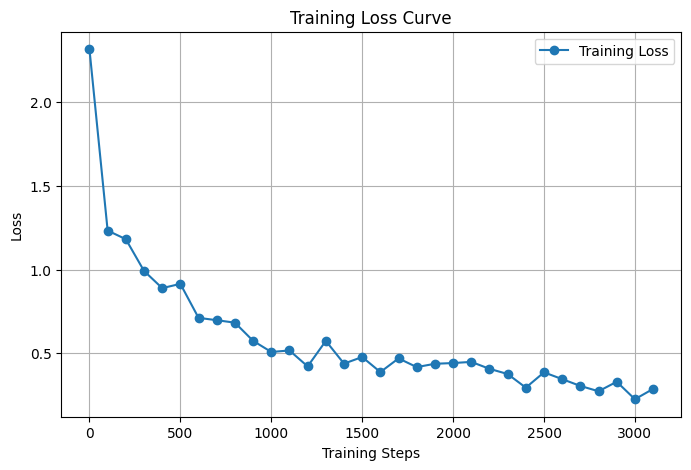

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Total test loss was -8.417751245498657
Accuracy was 85.9


In [5]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries
model = ResNet18()
device = torch.device("cuda")
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

_, losses = train(model, device, train_loader, optimizer, 16)

steps = [i * 100 for i in range(len(losses))]

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o', label="Training Loss")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# run test
test(model, device, test_loader)